In [1]:
import pandas as pd
import ipywidgets as w
from IPython.display import display, IFrame
import math, re, numpy as np, pyspark, glob
from urllib.parse import quote
from urllib.request import Request, urlopen
from google_images_download import google_images_download
from pyspark.sql import SQLContext, functions, types
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sc=pyspark.SparkContext(appName="hotel_recc")
spark = SQLContext(sc)

In [2]:
name = w.Text(description="User Name")
place = w.Text(description="Destination")
# budget = w.IntRangeSlider(min=att_df.price.min(), max=att_df.price.max(),step=10,value=[att_df.price.min(),att_df.price.max()],description="Budget")
out = w.VBox([name,place])
display(out)

In [6]:
start = w.DatePicker(description='Start Date',disabled=False)
display(start)
end = w.DatePicker(description='End Date',disabled=False)
display(end)

DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [7]:
del_dup = spark.read.json('project/del_dup')
newh_df = spark.read.json('project/newh_df')
del_dup.createOrReplaceTempView('del_dup')

In [8]:
strip_udf = functions.udf(lambda x: re.sub(r'[^\w\s]','',x), types.StringType())
newh_df = newh_df.withColumn("amenities", strip_udf(functions.col("amenities")))
newh_df.createOrReplaceTempView('newh_df')
newh1_df  = spark.sql("SELECT amenities,COUNT(amenities) AS tot_count FROM newh_df GROUP BY amenities ORDER BY tot_count DESC")
top_amenities = [x[0] for x in newh1_df.head(16) if x[0] != '']

In [9]:
amenities_pref = []
def on_button_clicked(b):
    if b.description in amenities_pref:
        return
    print(b.description)
    amenities_pref.append(b.description)
    if(len(amenities_pref) < 5):
        print("Select {x} more!\n".format(x=5-len(amenities_pref)))
        
but_layout = w.Layout(width='100%', height='100px')
but_items = [w.Button(description=c, layout=but_layout) for c in top_amenities]
on_clk = [item.on_click(on_button_clicked) for item in but_items]
r1 = w.VBox([i for i in but_items[:5]])
r2 = w.VBox([i for i in but_items[5:10]])
r3 = w.VBox([i for i in but_items[10:]])
buttons = w.HBox([r1,r2,r3])
print("Select atleast 5 amenities:")
display(buttons)

Select atleast 5 amenities:


 Nonsmoking rooms
Select 4 more!

 Free High Speed Internet WiFi
Select 3 more!

 Pets Allowed  Dog  Pet Friendly 
Select 2 more!

 Breakfast included
Select 1 more!

 Kitchenette


In [10]:
pa_df = pd.DataFrame(amenities_pref,columns=["amenities_pref"])

a_df = spark.createDataFrame(pa_df)
a_df.createOrReplaceTempView('a_df')

newa_df  = spark.sql("SELECT * FROM newh_df INNER JOIN a_df WHERE newh_df.amenities=a_df.amenities_pref")

ameni_comb = newa_df.groupBy(functions.col("id")).agg(functions.collect_list(functions.col("amenities")).alias("amenities"))
amenities_len=ameni_comb.withColumn("ameni_len",functions.size(ameni_comb["amenities"])).orderBy(functions.col("ameni_len"), ascending=False)
amenities_len.createOrReplaceTempView("amenities_len")

ameni_df = spark.sql("SELECT a.id,h.amenities,a.ameni_len FROM del_dup h INNER JOIN amenities_len a WHERE h.id=a.id ORDER BY a.ameni_len DESC")

In [11]:
def get_rating(x):
    val = x / 5
    if x >= 0 and x <= val:
        return 1
    elif x > val and x <= 2*val:
        return 2
    elif x > 2*val and x <= 3*val:
        return 3
    elif x > 3*val and x <= 4*val:
        return 4
    else:
        return 5

find_rating = functions.udf(lambda a: get_rating(a), types.IntegerType())

usr_rating = ameni_df.withColumn("rating",find_rating("ameni_len"))

In [12]:
u_id_df = spark.read.json('project/u_id_df')
u_id_df.createOrReplaceTempView('u_id_df')
uid_count = u_id_df.select("user_id").distinct().count()

usrid_df = usr_rating.withColumn("usr_id", functions.lit(uid_count)).join(u_id_df.select(["id","att_id"]), "id")

usrid_final_df = usrid_df.select(usrid_df["usr_id"].alias("user_id"),usrid_df["att_id"].alias("att_id"),usrid_df["rating"].alias("user_rating"))

org_df = u_id_df.select("user_id","att_id","user_rating")

(usrid_s1, usrid_s2) = usrid_final_df.randomSplit([0.1,0.9])

comb_df = org_df.union(usrid_s1)

rank :  12
RMSE:4.040381085004982


<BarContainer object of 3 artists>

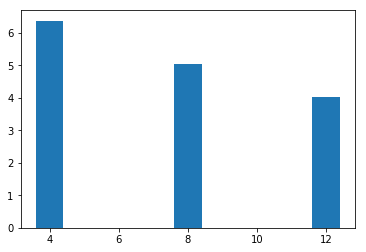

In [13]:
(training,validation) = comb_df.randomSplit([0.8,0.2])

ranks=[4,8,12]
error = 20000
errors = []
for i in ranks:
    als = ALS(maxIter=5,regParam=0.01,rank=i,userCol="user_id",itemCol="att_id",ratingCol="user_rating",coldStartStrategy="drop")
    model = als.fit(training)
    predictions = model.transform(validation)
    evaluator = RegressionEvaluator(metricName="rmse",labelCol="user_rating",predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    errors.append(rmse)
    if rmse < error:
        model.write().overwrite().save("model_file")
        rank = i
        error = rmse   
print("rank : ",rank)
print("RMSE:" +str(rmse))
plt.bar(ranks, height=errors)

In [14]:
als_model = ALSModel.load("model_file")

user = usrid_s2.select("user_id").distinct()
recomm = als_model.recommendForUserSubset(user,50)
recomm.createOrReplaceTempView('recomm')

recomm_df  = spark.sql("SELECT user_id,explode(recommendations) as recommendations FROM recomm")

get_attid = recomm_df.withColumn("att_id",functions.col("recommendations.att_id")).withColumn("rating",functions.col("recommendations.rating"))
get_attid.createOrReplaceTempView("get_attid")

u_id_df.createOrReplaceTempView('u_id_df')
u_tempdf = spark.sql("SELECT u_id_df.id FROM u_id_df INNER JOIN get_attid on u_id_df.att_id=get_attid.att_id")
u_tempdf.createOrReplaceTempView('u_tempdf')

In [15]:
# h_df = pd.read_json('dataset/hotel_info.json')
# h1_df = spark.createDataFrame(h_df).cache()
# h1_df.createOrReplaceTempView('h1_df')
# hotel_df = spark.sql("SELECT h1_df.* FROM h1_df INNER JOIN u_tempdf ON h1_df.id = u_tempdf.id")
hotel_df = del_dup.withColumn("address",functions.lower(functions.col("address")))

In [16]:
user_location = place.value.lower()
# geolocator = Nominatim(user_agent="new_recomm")

# def get_cname(x):
#     if 'nil' in x[1:-1]:
#         return "None"
#     else:
#         location = geolocator.reverse(x[1:-1], timeout=None)
#         if 'city' in location.raw["address"]:
#             return location.raw["address"]["city"]
#         elif 'town' in location.raw["address"]:
#             return location.raw["address"]["town"]
#         else:
#             return "None"
    
# get_city = functions.udf(lambda a:get_cname(a),types.StringType())

# city_df = hotel_df.withColumn("city",get_city(functions.col("location"))).cache()

In [17]:
hotel_sugg = hotel_df.where(hotel_df.address.contains(user_location))
# city_df.createOrReplaceTempView('city_df')
# spark.sql('SELECT * FROM city_df WHERE city=={user_location}'.format(user_location='london')).show()
# hotel_sugg.show()

In [18]:
prices = [float(i[0]) for i in hotel_sugg.select("price").dropna().collect() if i[0] != 'NaN']
prices
if(len(prices) == 0):
    over_prices = [float(i[0]) for i in hotel_df.select("price").dropna().collect() if i[0] != 'NaN']
    avg_price = sum(over_prices)/len(over_prices)
else:
    avg_price = sum(prices)/len(prices)
avg_price_df = hotel_sugg.withColumn('price',functions.when(functions.isnan(functions.col("price")), functions.lit(avg_price)).otherwise(functions.col("price")))

In [19]:
recc = avg_price_df.dropna().toPandas()

In [33]:
recc

,address,amenities,country,hotel_experience,hotel_name,hotel_rating,id,location,price
0,760 arthur st w thunder bay ontario,"[['Pool', 'Free parking', 'Free High Speed I...",Canada,Excellent,Hampton Inn & Suites by Hilton Thunder Bay,4.5,1677,"(48.3807093522627, -89.303340876481)",115.6044776119403
1,3 canal st east ontario,"[['Free parking', 'Free High Speed Internet (...",Canada,Excellent,New Rockland Motel,4.5,1950,"(42.2661898, -82.4143038)",115.6044776119403
2,3343 egremont dr strathroy ontario,"[['Free High Speed Internet (WiFi)', 'Non-smo...",Canada,Average,Country Side Motel,3.0,5385,"(43.0047258, -81.5510859)",115.6044776119403
3,141 king st e kingston ontario,"[['Free parking', 'Free High Speed Internet (...",Canada,Very good,Hotel Belvedere,4.0,1258,"(44.22531315625, -76.4856332875)",129.0
4,23 country club dr kingston ontario,"[['Free parking', 'Free High Speed Internet (...",Canada,Very good,St Lawrence College Kingston Residence and Con...,3.5,1277,"(44.2212123331933, -76.5302408708117)",115.6044776119403
5,111 staye court dr arnprior ontario,"[['Free High Speed Internet (WiFi)', 'Free pa...",Canada,Excellent,Country Squire Motel,4.5,5418,"(45.4232131308741, -76.3727240755299)",115.6044776119403
6,570 lakeshore dr north bay ontario,"[['Free parking', 'Breakfast included', 'Fre...",Canada,Very good,Super 8 by Wyndham North Bay,4.0,2989,"(46.2709732, -79.4422491054102)",115.6044776119403
7,255 mcintyre st w north bay ontario,"[['Free parking', 'Free High Speed Internet (...",Canada,Average,Howard Johnson by Wyndham North Bay,3.0,2994,"(46.3143624, -79.4659675)",115.6044776119403
8,600 highway 7 richmond hill ontario,"[['Pool', 'Room service', 'Free parking', '...",Canada,Very good,Sheraton Parkway Toronto North Hotel & Suites,3.5,5079,"(43.8458994, -79.380003942761)",115.6044776119403
9,180 macdougall st thunder bay ontario,"[['Free parking', 'Free High Speed Internet (...",Canada,Very good,Nights Inn Motel,3.5,1690,"(48.448869, -89.1947943)",115.6044776119403


In [20]:
def get_image(name):
    name = re.sub(' ','_',name)
    response = google_images_download.googleimagesdownload()
    args_list = ["keywords", "keywords_from_file", "prefix_keywords", "suffix_keywords",
             "limit", "format", "color", "color_type", "usage_rights", "size",
             "exact_size", "aspect_ratio", "type", "time", "time_range", "delay", "url", "single_image",
             "output_directory", "image_directory", "no_directory", "proxy", "similar_images", "specific_site",
             "print_urls", "print_size", "print_paths", "metadata", "extract_metadata", "socket_timeout",
             "thumbnail", "language", "prefix", "chromedriver", "related_images", "safe_search", "no_numbering",
             "offset", "no_download"]
    args = {}
    for i in args_list:
        args[i]= None
    args["keywords"] = name
    args['limit'] = 1
    params = response.build_url_parameters(args)
    url = 'https://www.google.com/search?q=' + quote(name) + '&espv=2&biw=1366&bih=667&site=webhp&source=lnms&tbm=isch' + params + '&sa=X&ei=XosDVaCXD8TasATItgE&ved=0CAcQ_AUoAg'
    try:
        response.download(args)
        for filename in glob.glob("downloads/{name}/*jpg".format(name=name)):
            return filename
    except:
        for filename in glob.glob("downloads/*jpg"):
            return filename

final = dict()
final['address'] = recc[:5]['address'].values.tolist()
final['amenities'] = recc[:5]['amenities'].values.T.tolist()
final['experience'] = recc[:5]['hotel_experience'].values.tolist()
final['name'] = recc[:5]['hotel_name'].values.tolist()
final['rating'] = recc[:5]['hotel_rating'].values.tolist()
final['location'] = [i[1:-1] for i in recc[:5]['location'].values.tolist()]
final['price'] = recc[:5]['price'].values.tolist()
final['image'] = [get_image(i) for i in recc[:5]['hotel_name'].values.tolist()]


Item no.: 1 --> Item name = Hampton_Inn_&_Suites_by_Hilton_Thunder_Bay
Evaluating...
Starting Download...
Completed Image ====> 1. 81070722.jpg

Errors: 0


Item no.: 1 --> Item name = New_Rockland_Motel
Evaluating...
Starting Download...
Completed Image ====> 1. new-rockland-motel.jpg

Errors: 0


Item no.: 1 --> Item name = Country_Side_Motel
Evaluating...
Starting Download...
Completed Image ====> 1. office.jpg

Errors: 0


Item no.: 1 --> Item name = Hotel_Belvedere
Evaluating...
Starting Download...
Completed Image ====> 1. testata-sito-con-widget.jpg

Errors: 0


Item no.: 1 --> Item name = St_Lawrence_College_Kingston_Residence_and_Conference_Centre
Evaluating...
Starting Download...
Completed Image ====> 1. photo1jpg

Errors: 0



In [21]:
days = (end.value - start.value).days
fields = ['NAME', 'PRICE', 'RATING', 'EXPERIENCE','LOCATION', 'ADDRESS', "AMENITIES"]
recommendations = ['Recommendation']

box_layout = w.Layout(justify_content='space-between',
                    display='flex',
                    flex_flow='row', 
                    align_items='stretch',
                   )
column_layout = w.Layout(justify_content='space-between',
                    width='75%',
                    display='flex',
                    flex_flow='column', 
                   )
tab = []
for i in range(len(final['name'])):
    image = open(final['image'][i], "rb").read()
    name = final['name'][i]
    price= final['price'][i]
    rating= final['rating'][i]
    experience= final['experience'][i]
    loc=final['location'][i]
    address=final['address'][i]
    amenities=final['amenities'][i]
    tab.append(w.VBox(children=
                    [
                     w.Image(value=image, format='jpg', width=300, height=400),
                     w.HTML(description=fields[0], value=f"<b><font color='black'>{name}</b>", disabled=True),
                     w.HTML(description=fields[1], value=f"<b><font color='black'>{price}</b>", disabled=True),
                     w.HTML(description=fields[2], value=f"<b><font color='black'>{rating}</b>", disabled=True), 
                     w.HTML(description=fields[3], value=f"<b><font color='black'>{experience}</b>", disabled=True), 
                     w.HTML(description=fields[4], value=f"<b><font color='black'>{loc}</b>", disabled=True),
                     w.HTML(description=fields[5], value=f"<b><font color='black'>{address}</b>", disabled=True)
                    ], layout=column_layout))
    
tab_recc = w.Tab(children=tab)
for i in range(len(tab_recc.children)):
    tab_recc.set_title(i, str('Hotel '+ str(i+1)))
tab_recc